In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import scipy.stats as st
from datetime import datetime
import gmaps
import os

# # Incorporated citipy to determine city based on latitude and longitude
# from citipy import citipy

# # Import API key
# from api_keys import g_key
# gmaps.configure(api_key=g_key)

In [2]:
# Make a reference to the starter csv file path and create df
prisoner_df = pd.read_csv('../Resources/Texas_Prison_Data.csv') 
prisoner_df.head()

,SID Number,TDCJ Number,Name,Current Facility,Gender,Race,Age,Projected Release,Maximum Sentence Date,Parole Eligibility Date,Case Number,County,Offense Code,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Last Parole Decision,Next Parole Review Date,Parole Review Status
0,234378,2174505,"LITTLE,AVA JESSUP",Young,F,W,75,10/01/2020,11/15/2025,09/26/2018,068770,Grayson,35990003,POSS CS 4-200G WID METH,12/14/2017,09/13/2017,8.0,Approved on 07/01/2020,NaN,NOT IN REVIEW PROCESS
1,524524,758486,"HARPER,DAVID JOHN JR",Estelle,M,W,91,01/01/9999,01/01/9999,08/03/2031,95-765-C,McLennan,36010001,INDECENCY WITH A CHILD,08/13/1996,09/15/1995,Life,None,08/03/2031,NOT IN REVIEW PROCESS
2,703267,841623,"RODRIGUEZ,THEODORE",Beto,M,W,82,08/03/2043,08/03/2043,02/01/2021,97-396-C,McLennan,11990003,AGG SEX ASLT,08/05/1998,06/01/1996,45.0,None,02/01/2021,IN PAROLE REVIEW PROCESS
3,708520,256174,"ALONZO,BENITO",Hospital Galveston,M,H,85,01/01/9999,01/01/9999,11/25/1985,49995,Travis,49030000,INTRODUCE DEADLY WPN PENAL INSTI,02/27/1976,06/01/1974,Life,Denied on 12/20/2019,12/2020,IN PAROLE REVIEW PROCESS
4,766785,365547,"BROWN,NARRIES EARL",Jester IV,M,W,84,01/01/9999,01/01/9999,08/24/2003,F83-89728-HI,Dallas,11220000,AGG SEX ABUSE CHILD/U14,08/24/1983,03/15/1983,Life,Denied on 12/05/2016,Unavailable at this time.,NOT IN REVIEW PROCESS


In [3]:
# prisoner_df.isna().sum()

In [4]:
# prisoner_df.dtypes

In [5]:
# This df is from the Texas Department of Criminal Justice (TDCJ)
# It has ALL the criminal code assignments - those that are currently being
# used AND those no longer used.  Some individuals have codes assigned that are no
# longer active.  This df has a column (Offense_Category)that can be used as a key 
# to link many different specific, detailed codes (Offense Codes) together.

offense_df = pd.read_csv('../Resources/offenseCodes_ut8.csv', encoding="utf-8")
# offense_df.head()

In [6]:
# offense_df.dtypes

In [7]:
# Create project specific df for merging. 
# This step creates a smaller dataframe that will be used to merge 
# with the prisoner df on the key offense cateogry

offproject_df = offense_df.loc[:,["Offense Code", "Offense_Category"]]
# offproject_df.head()

In [8]:
# This step actually creates the "bins" - the last column "Offense_Category" can be sorted on
# and capture the respective individuals by offense type.  The "ffill" will place a Nan in 
# the "Offense_Category" column if there is no value in that location.  
# The "merge_ordered" maintains the integrity of the elements in the order of the main df,
# prisoner_df, while matching the Offense_Cateogry" with the respective "Offense Code".
# The prisoner df has approximately 208K rows with many duplicated Offense Code.  
# The offproject df has 2,738 rows of 62 unique Offense Cateogries and related Offense Codes
# which results in the 2,738 rows on information in the df.  The Offense Code column is mapped
# to the respective value in the prisoner df and Offense_Category is assigned to the respective row.

binlookup_df = pd.merge_ordered(prisoner_df, offproject_df, fill_method='ffill', left_by='Offense Code')
binlookup_df.head()

,SID Number,TDCJ Number,Name,Current Facility,Gender,Race,Age,Projected Release,Maximum Sentence Date,Parole Eligibility Date,...,County,Offense Code,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Last Parole Decision,Next Parole Review Date,Parole Review Status,Offense_Category
0,234378,2174505,"LITTLE,AVA JESSUP",Young,F,W,75,10/01/2020,11/15/2025,09/26/2018,...,Grayson,35990003,POSS CS 4-200G WID METH,12/14/2017,09/13/2017,8.0,Approved on 07/01/2020,NaN,NOT IN REVIEW PROCESS,2200
1,1116232,1366652,"SIDLE,JOHN ARTHUR",Pack,M,W,78,05/02/2021,06/18/2033,03/08/2016,...,Dallas,35990003,UNLAW POSS WIT C/S-METHAM,04/06/2006,09/03/2004,25.0,Approved on 09/17/2020,NaN,NOT IN REVIEW PROCESS,2200
2,1409034,729430,"LERMA,GILBERT LOPEZ",Wynne,M,H,70,01/01/9999,01/01/9999,08/22/2020,...,Williamson,35990003,DEL C/S,09/19/1995,09/28/1994,Life,Denied on 07/16/2020,07/2021,NOT IN REVIEW PROCESS,2200
3,1468825,2205051,"EVANS,DAYTON BUD",Pack,M,W,70,04/21/2028,03/11/2043,10/20/2020,...,Grayson,35990003,POSS CONT SUB PG1 4-200 WITD,03/12/2018,03/31/2017,25.0,Denied on 08/13/2020,08/2021,NOT IN REVIEW PROCESS,2200
4,1473183,2038325,"GREEN,ROGER DALE SR",Duncan,M,W,73,08/16/2025,06/27/2040,02/14/2018,...,Johnson,35990003,DEL CONT SUB 4G-200G,11/10/2015,05/05/2015,25.0,Denied on 02/06/2020,02/2021,NOT IN REVIEW PROCESS,2200


In [9]:
binlookup_df.isna().sum()

SID Number                     0
TDCJ Number                    0
Name                           0
Current Facility               0
Gender                         0
Race                           0
Age                            0
Projected Release              0
Maximum Sentence Date         28
Parole Eligibility Date     9017
Case Number                   99
County                         0
Offense Code                   0
TDCJ Offense                   0
Sentence Date               1233
Offense Date                   0
Sentence (Years)               1
Last Parole Decision        7815
Next Parole Review Date    22397
Parole Review Status        7815
Offense_Category               0
dtype: int64

In [10]:
#Created this to keep from corrupting the good file
#did not need to do this - did not want issues a 2:37am
backup_df = binlookup_df.copy()

In [11]:
#This identifies the unique Offense Catrgory in the prisoner (newly creaked binlookup)
# df.  There are a total of 62 offense catories overall and 45 were matched to the prisoners
# in the prisoner df when creating the merged_ordered df.

binlookup_df["Offense_Category"].unique()

array([2200,  400, 3200,  200,  500, 4200,  600, 1500, 3700, 1900,  900,
       1600, 1800, 3500, 2300,  300, 6200, 4600, 4500,  700, 3400, 3100,
       4900, 3600, 1200, 2400, 2900, 2700,  100, 4100, 2100, 2600, 4300,
       3300, 3900, 1100, 2500, 6100, 5300, 1400, 5200, 4700, 5500, 5400],
      dtype=int64)

In [12]:
# Create bins in which to place values based upon Offense Categories
# The step serves the purpose of assigning a label to the respective offense category
# must have 1 extra bin then actual catorgies - hence the 0 at the beginning

bins = [0, 100, 200, 300, 400, 500, 600, 700, 900, 1100, 1200, 1400, 
        1500, 1600, 1800, 1900, 2100, 2200, 2300, 2400, 2500, 2600, 
        2700, 2900, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3900, 
        4100, 4200, 4300, 4400, 4500, 4600, 4700, 4900, 5200, 5300, 
        5400, 5500, 6100, 6200]

# Create labels for these bins
group_labels = ["Human_Trafficking", "Murder", "Kidnapping", "Sexual_Assault", "Robbery", "Assault",
                "Coercion_Politics", "Harrassment", "Terrorism", "Arson", "Unlawful_Use", "Burglary", "Theft",
                "Unlawful_Rep", "Fraud_Forgery", "Vandalism", "Drugs", "Sexual_Related_Materials", "Child_Endanger", "Bigamy",
                "Elderly_at_Risk_Adult_Endanger", "Violate_Order", "Prostitution", "Evading_Arrest", "Criminal_Escape",
                "Perjury_Contemp", "Jump_Bail_No_Show", "Interference_Records", "Bribery", "Weapon_Related", 
                "Riot_Obstruction", "Vehicle_Incident", "Alcohol_Incident", "Animal_Related", "Agriculture_Related",
                "Health_Code", "Hazardous_Material", "Discrimination_Civil_Rights", "Record_Tampering", "Tax_Evasion",
                "Pollution", "Money_Laundering", "Negligence", "Business_License", "Organized_Crime"]

In [13]:
# Slice the data and place it into bins
# pd.cut(binlookup_df["Offense_Category"], bins, labels=group_labels).head()

In [14]:
# Place the data series (offense category label) into a new (last) column inside of the DataFrame

binlookup_df["Bin_Cat"] = pd.cut(binlookup_df["Offense_Category"], bins, labels=group_labels)
binlookup_df.head()

,SID Number,TDCJ Number,Name,Current Facility,Gender,Race,Age,Projected Release,Maximum Sentence Date,Parole Eligibility Date,...,Offense Code,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Last Parole Decision,Next Parole Review Date,Parole Review Status,Offense_Category,Bin_Cat
0,234378,2174505,"LITTLE,AVA JESSUP",Young,F,W,75,10/01/2020,11/15/2025,09/26/2018,...,35990003,POSS CS 4-200G WID METH,12/14/2017,09/13/2017,8.0,Approved on 07/01/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs
1,1116232,1366652,"SIDLE,JOHN ARTHUR",Pack,M,W,78,05/02/2021,06/18/2033,03/08/2016,...,35990003,UNLAW POSS WIT C/S-METHAM,04/06/2006,09/03/2004,25.0,Approved on 09/17/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs
2,1409034,729430,"LERMA,GILBERT LOPEZ",Wynne,M,H,70,01/01/9999,01/01/9999,08/22/2020,...,35990003,DEL C/S,09/19/1995,09/28/1994,Life,Denied on 07/16/2020,07/2021,NOT IN REVIEW PROCESS,2200,Drugs
3,1468825,2205051,"EVANS,DAYTON BUD",Pack,M,W,70,04/21/2028,03/11/2043,10/20/2020,...,35990003,POSS CONT SUB PG1 4-200 WITD,03/12/2018,03/31/2017,25.0,Denied on 08/13/2020,08/2021,NOT IN REVIEW PROCESS,2200,Drugs
4,1473183,2038325,"GREEN,ROGER DALE SR",Duncan,M,W,73,08/16/2025,06/27/2040,02/14/2018,...,35990003,DEL CONT SUB 4G-200G,11/10/2015,05/05/2015,25.0,Denied on 02/06/2020,02/2021,NOT IN REVIEW PROCESS,2200,Drugs


In [15]:
rcbinlookup_df = binlookup_df.rename(columns={"SID Number": "SID_Number", 
                            "TDCJ Number": "TDCJ_Number",
                            "Current Facility" : "Current_Facility",
                            "Projected Release" : "Projected_Release",
                            "Maximum Sentence Date" : "Max_Sentence_Date",
                            "Parole Eligibility Date" : "Parole_Eligible_Date",
                            "Case Number" : "Case_Number",
                            "Offense Code" :"Offense_Code",
                            "TDCJ Offense" :"TDCJ_Offence",
                            "Sentence Date" : "Sentence_Date",
                            "Offense Date": "Offense_Date",
                            "Sentence (Years)" : "Sentence_Years",
                            "Last Parole Decision" : "Last_Parole_Decision",
                            "Next Parole Review Date" : "Next_Parole_Review",
                            "Parole Review Status" : "Parole_Review_Status"})

In [16]:
rcbinlookup_df["Sentence_Years"].unique()

array(['8.0', '25.0', 'Life', '12.0', '17.0', '15.0', '10.0', '18.0',
       '65.0', '22.0', '30.0', '35.0', '40.0', '60.0', '5.0', '9.0',
       '50.0', '16.0', '20.0', '3.0', '7.0', '23.0', '75.0', '70.0',
       '99.0', '14.0', '6.0', '45.0', '54.0', '13.0', '26.0', '28.0',
       '19.0', '24.0', '85.0', '33.0', '27.0', '49.0', '11.0', '29.0',
       '32.0', '55.0', '80.0', '9.5', '21.0', '13.5', '68.0', '90.0',
       '48.0', '78.0', '8.5', '37.0', '95.0', '4.0', '42.0', '43.0',
       '56.0', '38.0', '36.0', '12.5', '47.0', '2.0', '15.5', '77.0',
       '44.0', '.7', '10.5', 'LWOP', '61.0', '2.5', '3.3', '12.6', '6.5',
       '3.5', '10.1', '1.5', '52.0', '7.5', '41.0', '52.5', '57.0',
       '31.0', '72.0', '53.0', '22.5', '17.5', '32.5', '62.0', '17.6',
       '130.0', '39.0', 'Capital Life', '198.0', '51.0', '119.0',
       '3000.0', '1000.0', '159.0', '98.0', '102.0', '114.0', '50.5',
       '58.0', '106.0', '46.0', '297.0', '67.0', '66.0', '104.0', '88.0',
       '69.0', '161

In [17]:
rcbinlookup_df.dtypes

SID_Number                 int64
TDCJ_Number                int64
Name                      object
Current_Facility          object
Gender                    object
Race                      object
Age                        int64
Projected_Release         object
Max_Sentence_Date         object
Parole_Eligible_Date      object
Case_Number               object
County                    object
Offense_Code               int64
TDCJ_Offence              object
Sentence_Date             object
Offense_Date              object
Sentence_Years            object
Last_Parole_Decision      object
Next_Parole_Review        object
Parole_Review_Status      object
Offense_Category           int64
Bin_Cat                 category
dtype: object

In [18]:
# rcbinlookup_df["Offense_Code"].unique()

In [19]:
rcbinlookup_df=rcbinlookup_df.replace(to_replace="Life",value="50.9")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="LWOP", value="100.9")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="Capital Life", value = "101.9") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="Death", value = "150.9")

#Not able to do NaN with this method
# Index 71997 SID_Number 4340086   TDCJ_Number 2319589 is the NaN
# rcbinlookup_df=rcbinlookup_df.replace(to_replace="NaN", value = "3999.9")

rcbinlookup_df.head()

,SID_Number,TDCJ_Number,Name,Current_Facility,Gender,Race,Age,Projected_Release,Max_Sentence_Date,Parole_Eligible_Date,...,Offense_Code,TDCJ_Offence,Sentence_Date,Offense_Date,Sentence_Years,Last_Parole_Decision,Next_Parole_Review,Parole_Review_Status,Offense_Category,Bin_Cat
0,234378,2174505,"LITTLE,AVA JESSUP",Young,F,W,75,10/01/2020,11/15/2025,09/26/2018,...,35990003,POSS CS 4-200G WID METH,12/14/2017,09/13/2017,8.0,Approved on 07/01/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs
1,1116232,1366652,"SIDLE,JOHN ARTHUR",Pack,M,W,78,05/02/2021,06/18/2033,03/08/2016,...,35990003,UNLAW POSS WIT C/S-METHAM,04/06/2006,09/03/2004,25.0,Approved on 09/17/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs
2,1409034,729430,"LERMA,GILBERT LOPEZ",Wynne,M,H,70,01/01/9999,01/01/9999,08/22/2020,...,35990003,DEL C/S,09/19/1995,09/28/1994,50.9,Denied on 07/16/2020,07/2021,NOT IN REVIEW PROCESS,2200,Drugs
3,1468825,2205051,"EVANS,DAYTON BUD",Pack,M,W,70,04/21/2028,03/11/2043,10/20/2020,...,35990003,POSS CONT SUB PG1 4-200 WITD,03/12/2018,03/31/2017,25.0,Denied on 08/13/2020,08/2021,NOT IN REVIEW PROCESS,2200,Drugs
4,1473183,2038325,"GREEN,ROGER DALE SR",Duncan,M,W,73,08/16/2025,06/27/2040,02/14/2018,...,35990003,DEL CONT SUB 4G-200G,11/10/2015,05/05/2015,25.0,Denied on 02/06/2020,02/2021,NOT IN REVIEW PROCESS,2200,Drugs


In [20]:
rcbinlookup_df["Sentence_Years"].unique()

array(['8.0', '25.0', '50.9', '12.0', '17.0', '15.0', '10.0', '18.0',
       '65.0', '22.0', '30.0', '35.0', '40.0', '60.0', '5.0', '9.0',
       '50.0', '16.0', '20.0', '3.0', '7.0', '23.0', '75.0', '70.0',
       '99.0', '14.0', '6.0', '45.0', '54.0', '13.0', '26.0', '28.0',
       '19.0', '24.0', '85.0', '33.0', '27.0', '49.0', '11.0', '29.0',
       '32.0', '55.0', '80.0', '9.5', '21.0', '13.5', '68.0', '90.0',
       '48.0', '78.0', '8.5', '37.0', '95.0', '4.0', '42.0', '43.0',
       '56.0', '38.0', '36.0', '12.5', '47.0', '2.0', '15.5', '77.0',
       '44.0', '.7', '10.5', '100.9', '61.0', '2.5', '3.3', '12.6', '6.5',
       '3.5', '10.1', '1.5', '52.0', '7.5', '41.0', '52.5', '57.0',
       '31.0', '72.0', '53.0', '22.5', '17.5', '32.5', '62.0', '17.6',
       '130.0', '39.0', '101.9', '198.0', '51.0', '119.0', '3000.0',
       '1000.0', '159.0', '98.0', '102.0', '114.0', '50.5', '58.0',
       '106.0', '46.0', '297.0', '67.0', '66.0', '104.0', '88.0', '69.0',
       '161.0', '

In [21]:
#these are global changes - so need to check at some point for data in other columns being inadvertently changed
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2024.9",value="6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2092.7", value="8.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2027.0", value = "10.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2026.4", value = "11.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2027.1",  value = "10.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2024.8",value="6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2024.7", value="7.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2023.5", value = "5.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2026.3", value = "8.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2020.8",  value = "5.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2022.4",value="8.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2019.8", value="10.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2022.2", value = "5.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2024.0", value = "6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2029.9",  value = "10.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2022.3",value="6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2027.9", value="8.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2023.4", value = "6.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2021.4", value = "6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2021.5",value="2.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2022.9", value="3.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2022.8", value = "4.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2023.0", value = "5.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2024.3",  value = "6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2021.6",value="4.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2021.2", value="5.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2022.7", value = "5.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2023.9", value = "4.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2025.1",  value = "9.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2020.5",value="1.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2019.5", value="4.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2029.5", value = "10.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2021.9", value = "10.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2025.0",  value = "6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2024.5",value="5.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2022.6", value="3.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2020.2", value = "2.0") 
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2030.0", value = "11.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2023.6",  value = "5.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2024.2",value="6.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2029.7",  value = "8.0")
rcbinlookup_df=rcbinlookup_df.replace(to_replace="2020.9",value="2.0")

# rcbinlookup_df

In [22]:
rcbinlookup_df["Sentence_Years"].unique()

array(['8.0', '25.0', '50.9', '12.0', '17.0', '15.0', '10.0', '18.0',
       '65.0', '22.0', '30.0', '35.0', '40.0', '60.0', '5.0', '9.0',
       '50.0', '16.0', '20.0', '3.0', '7.0', '23.0', '75.0', '70.0',
       '99.0', '14.0', '6.0', '45.0', '54.0', '13.0', '26.0', '28.0',
       '19.0', '24.0', '85.0', '33.0', '27.0', '49.0', '11.0', '29.0',
       '32.0', '55.0', '80.0', '9.5', '21.0', '13.5', '68.0', '90.0',
       '48.0', '78.0', '8.5', '37.0', '95.0', '4.0', '42.0', '43.0',
       '56.0', '38.0', '36.0', '12.5', '47.0', '2.0', '15.5', '77.0',
       '44.0', '.7', '10.5', '100.9', '61.0', '2.5', '3.3', '12.6', '6.5',
       '3.5', '10.1', '1.5', '52.0', '7.5', '41.0', '52.5', '57.0',
       '31.0', '72.0', '53.0', '22.5', '17.5', '32.5', '62.0', '17.6',
       '130.0', '39.0', '101.9', '198.0', '51.0', '119.0', '3000.0',
       '1000.0', '159.0', '98.0', '102.0', '114.0', '50.5', '58.0',
       '106.0', '46.0', '297.0', '67.0', '66.0', '104.0', '88.0', '69.0',
       '161.0', '

In [23]:
rcbinlookup_df.loc[rcbinlookup_df["Sentence_Years"] == "800.0"]

,SID_Number,TDCJ_Number,Name,Current_Facility,Gender,Race,Age,Projected_Release,Max_Sentence_Date,Parole_Eligible_Date,...,Offense_Code,TDCJ_Offence,Sentence_Date,Offense_Date,Sentence_Years,Last_Parole_Decision,Next_Parole_Review,Parole_Review_Status,Offense_Category,Bin_Cat
90279,1436401,219085,"HEMPHILL,SAMUEL",Wynne,M,B,69,03/02/2309,01/19/2779,10/02/2030,...,11020000,RAPE,04/13/1970,10/30/1969,800.0,None,10/02/2030,NOT IN REVIEW PROCESS,400,Sexual_Assault


In [24]:
# nanloc_df = rcbinlookup_df[pd.to_numeric(rcbinlookup_df['Sentence_Years'], errors='coerce').isnull()]
# nanloc_df

# 	SID_Number	TDCJ_Number	Name	Current_Facility	Gender	Race	Age	Projected_Release	Max_Sentence_Date	Parole_Eligible_Date	...	Offense_Code	TDCJ_Offence	Sentence_Date	Offense_Date	Sentence_Years	Last_Parole_Decision	Next_Parole_Review	Parole_Review_Status	Offense_Category	Bin_Cat
# 71997	4340086	2319589	DAVIS,CHARLES ELLIS	Estelle	M	W	49	06/29/2021	NaN	NaN	...	35990015	POSS CONT SUB 1-4G	04/14/2020	07/30/2019	NaN	NaN	NaN	NaN	2200	Drugs



In [25]:
rcbinlookup_df.loc[71997,"Sentence_Years"] = 10.0

In [26]:
# rcbinlookup_df["Sentence_Years"].unique()

In [27]:
# Create age bins
# must have 1 extra bin then actual catorgies - hence the 0 at the beginning

agebins = [0, 19.9, 29.9, 39.9, 49.9, 59.9, 69.9, 79.9, 89.9, 99.9, 199.9]

# Create labels for these bins
agegroup_labels = ["Less_Than_20", "20_to_30", "30_to_40",
                   "40_to_50", "50_to_60", "60_to_70",
                   "70_to_80", "80_to_90", "90_to_100", "Greater_than_100"]   

In [28]:
# Create new column - Age_Bin

rcbinlookup_df["Age_Bin"] = pd.cut(rcbinlookup_df["Age"], agebins, labels=agegroup_labels)
rcbinlookup_df.head()

,SID_Number,TDCJ_Number,Name,Current_Facility,Gender,Race,Age,Projected_Release,Max_Sentence_Date,Parole_Eligible_Date,...,TDCJ_Offence,Sentence_Date,Offense_Date,Sentence_Years,Last_Parole_Decision,Next_Parole_Review,Parole_Review_Status,Offense_Category,Bin_Cat,Age_Bin
0,234378,2174505,"LITTLE,AVA JESSUP",Young,F,W,75,10/01/2020,11/15/2025,09/26/2018,...,POSS CS 4-200G WID METH,12/14/2017,09/13/2017,8.0,Approved on 07/01/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs,70_to_80
1,1116232,1366652,"SIDLE,JOHN ARTHUR",Pack,M,W,78,05/02/2021,06/18/2033,03/08/2016,...,UNLAW POSS WIT C/S-METHAM,04/06/2006,09/03/2004,25.0,Approved on 09/17/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs,70_to_80
2,1409034,729430,"LERMA,GILBERT LOPEZ",Wynne,M,H,70,01/01/9999,01/01/9999,08/22/2020,...,DEL C/S,09/19/1995,09/28/1994,50.9,Denied on 07/16/2020,07/2021,NOT IN REVIEW PROCESS,2200,Drugs,70_to_80
3,1468825,2205051,"EVANS,DAYTON BUD",Pack,M,W,70,04/21/2028,03/11/2043,10/20/2020,...,POSS CONT SUB PG1 4-200 WITD,03/12/2018,03/31/2017,25.0,Denied on 08/13/2020,08/2021,NOT IN REVIEW PROCESS,2200,Drugs,70_to_80
4,1473183,2038325,"GREEN,ROGER DALE SR",Duncan,M,W,73,08/16/2025,06/27/2040,02/14/2018,...,DEL CONT SUB 4G-200G,11/10/2015,05/05/2015,25.0,Denied on 02/06/2020,02/2021,NOT IN REVIEW PROCESS,2200,Drugs,70_to_80


In [143]:
###### Avg sentence per crime bin ###### Cade
sentence_df = rcbinlookup_df[["Bin_Cat", "Sentence_Years", "Offense_Category"]]
sentence_df['Sentence_Years'] = sentence_df['Sentence_Years'].astype(float)
sentence_df

<ipython-input-143-56ba19f62bb9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentence_df['Sentence_Years'] = sentence_df['Sentence_Years'].astype(float)


,Bin_Cat,Sentence_Years,Offense_Category
0,Drugs,8.0,2200
1,Drugs,25.0,2200
2,Drugs,50.9,2200
3,Drugs,25.0,2200
4,Drugs,25.0,2200
...,...,...,...
120702,Human_Trafficking,5.0,100
120703,Unlawful_Use,8.0,1400
120704,Theft,10.0,1600
120705,Sexual_Assault,2.0,400


In [30]:
#All crime bins that will be represented
total_bin_cat = sentence_df["Bin_Cat"].value_counts()
total_bin_cat

Sexual_Assault                    22052
Assault                           17812
Robbery                           17630
Drugs                             17151
Murder                            14937
Burglary                           7165
Alcohol_Incident                   4874
Evading_Arrest                     4149
Weapon_Related                     2852
Theft                              2216
Fraud_Forgery                      1463
Record_Tampering                   1139
Sexual_Related_Materials           1106
Kidnapping                         1067
Arson                               590
Jump_Bail_No_Show                   580
Unlawful_Rep                        565
Hazardous_Material                  526
Coercion_Politics                   420
Harrassment                         400
Interference_Records                328
Vehicle_Incident                    306
Violate_Order                       226
Criminal_Escape                     223
Human_Trafficking                   209


In [31]:
#Sexual Assault
s_assault_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Sexual_Assault", :]
s_assault_df

,Bin_Cat,Sentence_Years,Offense_Category
4808,Sexual_Assault,50.9,400
4809,Sexual_Assault,22.0,400
4810,Sexual_Assault,15.0,400
4811,Sexual_Assault,8.0,400
4812,Sexual_Assault,7.0,400
...,...,...,...
120656,Sexual_Assault,4.0,400
120657,Sexual_Assault,20.0,400
120658,Sexual_Assault,20.0,400
120659,Sexual_Assault,8.0,400


In [32]:
avg_s_assault = s_assault_df['Sentence_Years'].mean()
avg_s_assault
r_avg_s_assault = round(avg_s_assault, 1)
r_avg_s_assault

27.9

In [33]:
#Assault
assault_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Assault", :]
assault_df

,Bin_Cat,Sentence_Years,Offense_Category
38916,Assault,50.9,600
38917,Assault,15.0,600
38918,Assault,10.0,600
38919,Assault,20.0,600
38920,Assault,3.0,600
...,...,...,...
120522,Assault,3.0,600
120534,Assault,50.0,600
120641,Assault,3.0,600
120642,Assault,3.0,600


In [34]:
avg_assault = assault_df['Sentence_Years'].mean()
avg_assault
r_avg_assault = round(avg_assault, 1)
r_avg_assault

14.9

In [35]:
#Robbery
robbery_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Robbery", :]
robbery_df

,Bin_Cat,Sentence_Years,Offense_Category
11578,Robbery,30.0,500
11579,Robbery,10.0,500
11580,Robbery,60.0,500
11581,Robbery,99.0,500
11582,Robbery,30.0,500
...,...,...,...
118251,Robbery,60.0,500
118252,Robbery,40.0,500
118253,Robbery,40.0,500
118254,Robbery,99.0,500


In [36]:
avg_robbery = robbery_df['Sentence_Years'].mean()
avg_robbery
r_avg_robbery = round(avg_robbery, 1)
r_avg_robbery

22.2

In [37]:
#Drugs
drugs_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Drugs", :]
drugs_df

,Bin_Cat,Sentence_Years,Offense_Category
0,Drugs,8.0,2200
1,Drugs,25.0,2200
2,Drugs,50.9,2200
3,Drugs,25.0,2200
4,Drugs,25.0,2200
...,...,...,...
120689,Drugs,8.0,2200
120690,Drugs,5.0,2200
120696,Drugs,0.9,2200
120699,Drugs,3.0,2200


In [38]:
avg_drugs = robbery_df['Sentence_Years'].mean()
avg_drugs
r_avg_drugs = round(avg_drugs, 1)
r_avg_drugs

22.2

In [39]:
#Murder
murder_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Murder", :]
murder_df

,Bin_Cat,Sentence_Years,Offense_Category
9748,Murder,50.9,200
9749,Murder,101.9,200
9750,Murder,50.9,200
9751,Murder,50.9,200
9752,Murder,50.9,200
...,...,...,...
120163,Murder,100.9,200
120164,Murder,150.9,200
120165,Murder,101.9,200
120166,Murder,100.9,200


In [40]:
avg_murder = murder_df['Sentence_Years'].mean()
avg_murder
r_avg_murder = round(avg_murder, 1)
r_avg_murder

56.0

In [41]:
#Burglary
burglary_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Burglary", :]
burglary_df

,Bin_Cat,Sentence_Years,Offense_Category
49259,Burglary,65.0,1500
49260,Burglary,50.9,1500
49261,Burglary,50.9,1500
49262,Burglary,50.9,1500
49263,Burglary,40.0,1500
...,...,...,...
118803,Burglary,50.0,1500
118804,Burglary,30.0,1500
119075,Burglary,15.0,1500
119392,Burglary,40.0,1500


In [42]:
avg_burglary = burglary_df['Sentence_Years'].mean()
avg_burglary
r_avg_burglary = round(avg_burglary, 1)
r_avg_burglary

17.9

In [43]:
#Alcohol Incident
alcohol_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Alcohol_Incident", :]
alcohol_df

,Bin_Cat,Sentence_Years,Offense_Category
26327,Alcohol_Incident,25.0,4200
26328,Alcohol_Incident,55.0,4200
26329,Alcohol_Incident,25.0,4200
26330,Alcohol_Incident,25.0,4200
26331,Alcohol_Incident,15.0,4200
...,...,...,...
120597,Alcohol_Incident,9.0,4200
120598,Alcohol_Incident,55.0,4200
120599,Alcohol_Incident,60.0,4200
120600,Alcohol_Incident,55.0,4200


In [44]:
avg_alcohol = alcohol_df['Sentence_Years'].mean()
avg_alcohol
r_avg_alcohol = round(avg_alcohol, 1)
r_avg_alcohol

12.8

In [45]:
#Evading Arrest
evade_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Evading_Arrest", :]
evade_df

,Bin_Cat,Sentence_Years,Offense_Category
84320,Evading_Arrest,20.0,3100
84321,Evading_Arrest,35.0,3100
84322,Evading_Arrest,60.0,3100
84323,Evading_Arrest,5.0,3100
84324,Evading_Arrest,25.0,3100
...,...,...,...
120528,Evading_Arrest,20.0,3100
120529,Evading_Arrest,8.0,3100
120556,Evading_Arrest,25.0,3100
120557,Evading_Arrest,15.0,3100


In [46]:
avg_evade = evade_df['Sentence_Years'].mean()
avg_evade
r_avg_evade = round(avg_evade, 1)
r_avg_evade

9.9

In [47]:
#Weapon Related
weapon_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Weapon_Related", :]
weapon_df

,Bin_Cat,Sentence_Years,Offense_Category
57331,Weapon_Related,10.0,3700
57332,Weapon_Related,6.0,3700
57333,Weapon_Related,3.0,3700
57334,Weapon_Related,25.0,3700
57335,Weapon_Related,70.0,3700
...,...,...,...
120573,Weapon_Related,10.0,3700
120635,Weapon_Related,2.0,3700
120636,Weapon_Related,5.0,3700
120648,Weapon_Related,4.0,3700


In [48]:
avg_weapon = weapon_df['Sentence_Years'].mean()
avg_weapon
r_avg_weapon = round(avg_weapon, 1)
r_avg_weapon

9.6

In [49]:
#Theft
theft_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Theft", :]
theft_df

,Bin_Cat,Sentence_Years,Offense_Category
59036,Theft,50.9,1600
59037,Theft,50.9,1600
59038,Theft,50.9,1600
59039,Theft,50.9,1600
59040,Theft,40.0,1600
...,...,...,...
120613,Theft,4.0,1600
120622,Theft,6.0,1600
120623,Theft,12.0,1600
120683,Theft,3.0,1600


In [50]:
avg_theft = theft_df['Sentence_Years'].mean()
avg_theft
r_avg_theft = round(avg_theft, 1)
r_avg_theft

9.6

In [51]:
#Fraud / Forgery
fraud_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Fraud_Forgery", :]
fraud_df

,Bin_Cat,Sentence_Years,Offense_Category
57460,Fraud_Forgery,50.9,1900
57461,Fraud_Forgery,25.0,1900
57462,Fraud_Forgery,45.0,1900
57463,Fraud_Forgery,35.0,1900
57464,Fraud_Forgery,25.0,1900
...,...,...,...
120669,Fraud_Forgery,6.0,1900
120675,Fraud_Forgery,50.9,1900
120691,Fraud_Forgery,4.0,1900
120692,Fraud_Forgery,10.0,1900


In [52]:
avg_fraud = fraud_df['Sentence_Years'].mean()
avg_fraud
r_avg_fraud = round(avg_fraud, 1)
r_avg_fraud

8.7

In [53]:
#Record Tampering
tamper_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Record_Tampering", :]
tamper_df

,Bin_Cat,Sentence_Years,Offense_Category
93291,Record_Tampering,17.0,4900
93292,Record_Tampering,5.0,4900
93293,Record_Tampering,50.0,4900
93294,Record_Tampering,35.0,4900
93295,Record_Tampering,40.0,4900
...,...,...,...
120677,Record_Tampering,15.0,4900
120678,Record_Tampering,12.0,4900
120679,Record_Tampering,8.0,4900
120680,Record_Tampering,3.0,4900


In [54]:
avg_tamper = tamper_df['Sentence_Years'].mean()
avg_tamper
r_avg_tamper = round(avg_tamper, 1)
r_avg_tamper

18.8

In [55]:
#Sexual Related Materials
srm_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Sexual_Related_Materials", :]
srm_df

,Bin_Cat,Sentence_Years,Offense_Category
67594,Sexual_Related_Materials,10.0,2300
67595,Sexual_Related_Materials,25.0,2300
67596,Sexual_Related_Materials,50.9,2300
67597,Sexual_Related_Materials,50.0,2300
67598,Sexual_Related_Materials,12.0,2300
...,...,...,...
120570,Sexual_Related_Materials,40.0,2300
120637,Sexual_Related_Materials,1.0,2300
120638,Sexual_Related_Materials,1.7,2300
120647,Sexual_Related_Materials,2.0,2300


In [56]:
avg_srm = srm_df['Sentence_Years'].mean()
avg_srm
r_avg_srm = round(avg_srm, 1)
r_avg_srm

11.8

In [57]:
#Kidnapping
kidnap_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Kidnapping", :]
kidnap_df

,Bin_Cat,Sentence_Years,Offense_Category
69792,Kidnapping,50.0,300
69793,Kidnapping,60.0,300
69794,Kidnapping,80.0,300
69795,Kidnapping,50.9,300
69796,Kidnapping,50.9,300
...,...,...,...
120489,Kidnapping,2.0,300
120490,Kidnapping,3.0,300
120543,Kidnapping,99.0,300
120618,Kidnapping,29.0,300


In [58]:
avg_kidnap = kidnap_df['Sentence_Years'].mean()
avg_kidnap
r_avg_kidnap = round(avg_kidnap, 1)
r_avg_kidnap

31.8

In [59]:
#Arson
arson_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Arson", :]
arson_df

,Bin_Cat,Sentence_Years,Offense_Category
100987,Arson,20.0,1200
100988,Arson,10.0,1200
100989,Arson,5.0,1200
100990,Arson,8.0,1200
100991,Arson,7.0,1200
...,...,...,...
120394,Arson,18.0,1200
120395,Arson,2.0,1200
120396,Arson,2.0,1200
120397,Arson,2.0,1200


In [60]:
avg_arson = arson_df['Sentence_Years'].mean()
avg_arson
r_avg_arson = round(avg_arson, 1)
r_avg_arson

17.4

In [61]:
#Jump_Bail_No_Show
noshow_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Jump_Bail_No_Show", :]
noshow_df

,Bin_Cat,Sentence_Years,Offense_Category
83764,Jump_Bail_No_Show,75.0,3400
83765,Jump_Bail_No_Show,6.0,3400
83766,Jump_Bail_No_Show,25.0,3400
83767,Jump_Bail_No_Show,3.0,3400
83768,Jump_Bail_No_Show,25.0,3400
...,...,...,...
114311,Jump_Bail_No_Show,1.2,3400
114312,Jump_Bail_No_Show,1.3,3400
119028,Jump_Bail_No_Show,30.0,3400
119268,Jump_Bail_No_Show,10.0,3400


In [62]:
avg_noshow = noshow_df['Sentence_Years'].mean()
avg_noshow
r_avg_noshow = round(avg_noshow, 1)
r_avg_noshow

10.3

In [63]:
#Unlawful_Rep
unlawrep_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Unlawful_Rep", :]
unlawrep_df

,Bin_Cat,Sentence_Years,Offense_Category
59564,Unlawful_Rep,28.0,1800
59565,Unlawful_Rep,25.0,1800
59566,Unlawful_Rep,3.0,1800
59567,Unlawful_Rep,10.0,1800
59568,Unlawful_Rep,2.0,1800
...,...,...,...
119663,Unlawful_Rep,1.2,1800
120184,Unlawful_Rep,10.0,1800
120185,Unlawful_Rep,8.0,1800
120186,Unlawful_Rep,43.0,1800


In [64]:
avg_unlawrep = unlawrep_df['Sentence_Years'].mean()
avg_unlawrep
r_avg_unlawrep = round(avg_unlawrep, 1)
r_avg_unlawrep

5.4

In [65]:
#Hazardous Material
hazmat_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Hazardous_Material", :]
hazmat_df

,Bin_Cat,Sentence_Years,Offense_Category
70050,Hazardous_Material,6.0,4600
70051,Hazardous_Material,10.0,4600
70052,Hazardous_Material,25.0,4600
70053,Hazardous_Material,4.0,4600
70054,Hazardous_Material,8.0,4600
...,...,...,...
70571,Hazardous_Material,3.0,4600
119412,Hazardous_Material,2.0,4600
119413,Hazardous_Material,1.5,4600
119847,Hazardous_Material,4.0,4600


In [66]:
avg_hazmat = hazmat_df['Sentence_Years'].mean()
avg_hazmat
r_avg_hazmat = round(avg_hazmat, 1)
r_avg_hazmat

5.8

In [67]:
#Coercion Politics
coercion_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Coercion_Politics", :]
coercion_df

,Bin_Cat,Sentence_Years,Offense_Category
82922,Coercion_Politics,20.0,700
82923,Coercion_Politics,30.0,700
82924,Coercion_Politics,30.0,700
82925,Coercion_Politics,40.0,700
82926,Coercion_Politics,30.0,700
...,...,...,...
111968,Coercion_Politics,3.0,700
111969,Coercion_Politics,8.0,700
111970,Coercion_Politics,10.0,700
111971,Coercion_Politics,5.0,700


In [68]:
avg_coercion = coercion_df['Sentence_Years'].mean()
avg_coercion
r_avg_coercion = round(avg_coercion, 1)
r_avg_coercion

21.6

In [69]:
#Harrassment
harrass_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Harrassment", :]
harrass_df

,Bin_Cat,Sentence_Years,Offense_Category
58297,Harrassment,8.0,900
58298,Harrassment,50.9,900
58299,Harrassment,20.0,900
58300,Harrassment,15.0,900
58301,Harrassment,8.0,900
...,...,...,...
117936,Harrassment,4.0,900
117937,Harrassment,5.0,900
117938,Harrassment,2.0,900
117939,Harrassment,3.0,900


In [70]:
avg_harrass = harrass_df['Sentence_Years'].mean()
avg_harrass
r_avg_harrass = round(avg_harrass, 1)
r_avg_harrass

7.2

In [71]:
#Interference Records
inter_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Interference_Records", :]
inter_df

,Bin_Cat,Sentence_Years,Offense_Category
67303,Interference_Records,25.0,3500
67304,Interference_Records,14.0,3500
67305,Interference_Records,5.0,3500
67306,Interference_Records,60.0,3500
67307,Interference_Records,2.0,3500
...,...,...,...
120041,Interference_Records,2.0,3500
120042,Interference_Records,4.0,3500
120043,Interference_Records,2.0,3500
120044,Interference_Records,5.0,3500


In [72]:
avg_inter = inter_df['Sentence_Years'].mean()
avg_inter
r_avg_inter = round(avg_inter, 1)
r_avg_inter

7.4

In [73]:
#Vehicle Incident
vehicle_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Vehicle_Incident", :]
vehicle_df

,Bin_Cat,Sentence_Years,Offense_Category
114463,Vehicle_Incident,14.0,4100
114464,Vehicle_Incident,1.0,4100
115551,Vehicle_Incident,35.0,4100
115552,Vehicle_Incident,60.0,4100
115553,Vehicle_Incident,60.0,4100
...,...,...,...
120607,Vehicle_Incident,10.0,4100
120608,Vehicle_Incident,7.0,4100
120609,Vehicle_Incident,5.0,4100
120610,Vehicle_Incident,10.0,4100


In [74]:
avg_vehicle = vehicle_df['Sentence_Years'].mean()
avg_vehicle
r_avg_vehicle = round(avg_vehicle, 1)
r_avg_vehicle

10.6

In [75]:
#Violate Order
vorder_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Violate_Order", :]
vorder_df

,Bin_Cat,Sentence_Years,Offense_Category
110109,Violate_Order,10.0,2700
110110,Violate_Order,20.0,2700
110111,Violate_Order,14.0,2700
110112,Violate_Order,5.0,2700
110113,Violate_Order,10.0,2700
...,...,...,...
117462,Violate_Order,2.0,2700
117463,Violate_Order,3.0,2700
117464,Violate_Order,4.0,2700
119726,Violate_Order,50.9,2700


In [76]:
avg_vorder = vorder_df['Sentence_Years'].mean()
avg_vorder
r_avg_vorder = round(avg_vorder, 1)
r_avg_vorder

7.5

In [77]:
#Criminal Escape
escape_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Criminal_Escape", :]
escape_df

,Bin_Cat,Sentence_Years,Offense_Category
9650,Criminal_Escape,50.9,3200
83229,Criminal_Escape,25.0,3200
83230,Criminal_Escape,81.0,3200
83231,Criminal_Escape,25.0,3200
83232,Criminal_Escape,99.0,3200
...,...,...,...
119861,Criminal_Escape,4.0,3200
119862,Criminal_Escape,5.0,3200
120423,Criminal_Escape,50.0,3200
120491,Criminal_Escape,12.0,3200


In [78]:
avg_escape = escape_df['Sentence_Years'].mean()
avg_escape
r_avg_escape = round(avg_escape, 1)
r_avg_escape

19.5

In [79]:
#Human Trafficking
traff_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Human_Trafficking", :]
traff_df

,Bin_Cat,Sentence_Years,Offense_Category
112918,Human_Trafficking,50.9,100
112919,Human_Trafficking,50.0,100
112920,Human_Trafficking,20.0,100
112921,Human_Trafficking,50.0,100
112922,Human_Trafficking,75.0,100
...,...,...,...
120619,Human_Trafficking,3.0,100
120620,Human_Trafficking,8.0,100
120621,Human_Trafficking,5.0,100
120697,Human_Trafficking,15.0,100


In [80]:
avg_traff = traff_df['Sentence_Years'].mean()
avg_traff
r_avg_traff = round(avg_traff, 1)
r_avg_traff

23.2

In [81]:
#Prostitution
prost_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Prostitution", :]
prost_df

,Bin_Cat,Sentence_Years,Offense_Category
109140,Prostitution,50.9,2900
114996,Prostitution,5.0,2900
114997,Prostitution,4.0,2900
114998,Prostitution,0.8,2900
114999,Prostitution,3.0,2900
...,...,...,...
120583,Prostitution,5.0,2900
120584,Prostitution,5.0,2900
120585,Prostitution,20.0,2900
120645,Prostitution,4.0,2900


In [82]:
avg_prost = prost_df['Sentence_Years'].mean()
avg_prost
r_avg_prost = round(avg_prost, 1)
r_avg_prost

13.8

In [83]:
#Child Endangerment
cdanger_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Child_Endanger", :]
cdanger_df

,Bin_Cat,Sentence_Years,Offense_Category
109136,Child_Endanger,60.0,2400
109137,Child_Endanger,10.0,2400
109138,Child_Endanger,20.0,2400
115896,Child_Endanger,7.0,2400
115897,Child_Endanger,25.0,2400
...,...,...,...
120453,Child_Endanger,1.0,2400
120550,Child_Endanger,2.0,2400
120591,Child_Endanger,4.0,2400
120639,Child_Endanger,4.0,2400


In [84]:
avg_cdanger = cdanger_df['Sentence_Years'].mean()
avg_cdanger
r_avg_cdanger = round(avg_cdanger, 1)
r_avg_cdanger

6.7

In [85]:
#Vandalism
vandal_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Vandalism", :]
vandal_df

,Bin_Cat,Sentence_Years,Offense_Category
114834,Vandalism,15.0,2100
114835,Vandalism,25.0,2100
117696,Vandalism,7.0,2100
117697,Vandalism,20.0,2100
117944,Vandalism,50.9,2100
...,...,...,...
120552,Vandalism,20.0,2100
120553,Vandalism,40.0,2100
120681,Vandalism,6.0,2100
120682,Vandalism,12.0,2100


In [86]:
avg_vandal = vandal_df['Sentence_Years'].mean()
avg_vandal
r_avg_vandal = round(avg_vandal, 1)
r_avg_vandal

8.3

In [87]:
#Health Code Violation
health_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Health_Code", :]
health_df

,Bin_Cat,Sentence_Years,Offense_Category
75169,Health_Code,8.0,4500
75170,Health_Code,50.9,4500
75171,Health_Code,10.0,4500
75172,Health_Code,15.0,4500
75173,Health_Code,20.0,4500
...,...,...,...
75225,Health_Code,25.0,4500
75226,Health_Code,15.0,4500
75227,Health_Code,20.0,4500
75228,Health_Code,5.0,4500


In [88]:
avg_health = health_df['Sentence_Years'].mean()
avg_health
r_avg_health = round(avg_health, 1)
r_avg_health

19.8

In [89]:
#Animal Related
animal_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Animal_Related", :]
animal_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
116027,Animal_Related,15.0,4300
116818,Animal_Related,20.0,4300
116819,Animal_Related,5.0,4300
116820,Animal_Related,25.0,4300
118569,Animal_Related,7.0,4300


In [90]:
avg_animal = animal_df['Sentence_Years'].mean()
avg_animal
r_avg_animal = round(avg_animal, 1)
r_avg_animal

8.8

In [91]:
#Terrorism
terror_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Terrorism", :]
terror_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
118372,Terrorism,4.0,1100
118373,Terrorism,20.0,1100
118374,Terrorism,5.0,1100
118375,Terrorism,1.0,1100
118376,Terrorism,3.0,1100


In [92]:
avg_terror = terror_df['Sentence_Years'].mean()
avg_terror
r_avg_terror = round(avg_terror, 1)
r_avg_terror

7.0

In [93]:
#Organized Crime
orgcrime_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Organized_Crime", :]
orgcrime_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
70030,Organized_Crime,45.0,6200
70031,Organized_Crime,50.9,6200
70032,Organized_Crime,50.9,6200
70033,Organized_Crime,80.0,6200
70034,Organized_Crime,75.0,6200


In [94]:
avg_orgcrime = orgcrime_df['Sentence_Years'].mean()
avg_orgcrime
r_avg_orgcrime = round(avg_orgcrime, 1)
r_avg_orgcrime

27.9

In [95]:
#Bribery
bribe_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Bribery", :]
bribe_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
99518,Bribery,25.0,3600
99519,Bribery,5.0,3600
99520,Bribery,6.0,3600
99521,Bribery,6.0,3600
99522,Bribery,5.0,3600


In [96]:
avg_bribe = bribe_df['Sentence_Years'].mean()
avg_bribe
r_avg_bribe = round(avg_bribe, 1)
r_avg_bribe

7.7

In [97]:
#Riot Obstruction
riot_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Riot_Obstruction", :]
riot_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
116919,Riot_Obstruction,15.0,3900
116920,Riot_Obstruction,45.0,3900
118828,Riot_Obstruction,5.0,3900
119575,Riot_Obstruction,5.0,3900
119576,Riot_Obstruction,7.0,3900


In [98]:
avg_riot = riot_df['Sentence_Years'].mean()
avg_riot
r_avg_riot = round(avg_riot, 1)
r_avg_riot

10.4

In [99]:
#Money Laundering
money_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Money_Laundering", :]
money_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
120170,Money_Laundering,5.0,5400
120171,Money_Laundering,6.0,5400
120363,Money_Laundering,2.0,5400
120364,Money_Laundering,6.0,5400
120365,Money_Laundering,5.0,5400


In [100]:
avg_money = money_df['Sentence_Years'].mean()
avg_money
r_avg_money = round(avg_money, 1)
r_avg_money

4.6

In [101]:
#Perjury Contemp
perj_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Perjury_Contemp", :]
perj_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
116813,Perjury_Contemp,50.9,3300
116814,Perjury_Contemp,25.0,3300
116815,Perjury_Contemp,8.0,3300
116816,Perjury_Contemp,10.0,3300
116817,Perjury_Contemp,4.0,3300


In [102]:
avg_perj = perj_df['Sentence_Years'].mean()
avg_perj
r_avg_perj = round(avg_perj, 1)
r_avg_perj

22.0

In [103]:
#Elderly at Risk/ Adult Endangerment
adanger_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Elderly_at_Risk_Adult_Endanger", :]
adanger_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
115543,Elderly_at_Risk_Adult_Endanger,7.0,2600
115544,Elderly_at_Risk_Adult_Endanger,8.0,2600
115545,Elderly_at_Risk_Adult_Endanger,25.0,2600
115546,Elderly_at_Risk_Adult_Endanger,8.0,2600
115547,Elderly_at_Risk_Adult_Endanger,20.0,2600


In [104]:
avg_adanger = adanger_df['Sentence_Years'].mean()
avg_adanger
r_avg_adanger = round(avg_adanger, 1)
r_avg_adanger

14.7

In [105]:
#Discrimination/ Civil Rights
civil_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Discrimination_Civil_Rights", :]
civil_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
119873,Discrimination_Civil_Rights,4.0,4700
119874,Discrimination_Civil_Rights,10.0,4700
119875,Discrimination_Civil_Rights,7.5,4700
119876,Discrimination_Civil_Rights,10.0,4700
119877,Discrimination_Civil_Rights,5.0,4700


In [106]:
avg_civil = civil_df['Sentence_Years'].mean()
avg_civil
r_avg_civil = round(avg_civil, 1)
r_avg_civil

7.8

In [107]:
#Business License
business_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Business_License", :]
business_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
119194,Business_License,40.0,6100
120005,Business_License,18.0,6100
120006,Business_License,4.0,6100
120007,Business_License,7.0,6100
120242,Business_License,6.0,6100


In [108]:
avg_business = business_df['Sentence_Years'].mean()
avg_business
r_avg_business = round(avg_business, 1)
r_avg_business

15.0

In [109]:
#Unlawful Use
unlawuse_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Unlawful_Use", :]
unlawuse_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
119735,Unlawful_Use,18.0,1400
119736,Unlawful_Use,7.0,1400
119737,Unlawful_Use,20.0,1400
120517,Unlawful_Use,1.0,1400
120703,Unlawful_Use,8.0,1400


In [110]:
avg_unlawuse = unlawuse_df['Sentence_Years'].mean()
avg_unlawuse
r_avg_unlawuse = round(avg_unlawuse, 1)
r_avg_unlawuse

10.8

In [111]:
#Tax Evasion
taxevade_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Tax_Evasion", :]
taxevade_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
119846,Tax_Evasion,40.0,5200
120476,Tax_Evasion,2.0,5200
120477,Tax_Evasion,15.0,5200
120478,Tax_Evasion,8.0,5200
120479,Tax_Evasion,5.0,5200


In [112]:
avg_taxevade = taxevade_df['Sentence_Years'].mean()
avg_taxevade
r_avg_taxevade = round(avg_taxevade, 1)
r_avg_taxevade

14.0

In [113]:
#Bigamy
bigamy_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Bigamy", :]
bigamy_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
118832,Bigamy,10.0,2500
120706,Bigamy,8.0,2500


In [114]:
avg_bigamy = bigamy_df['Sentence_Years'].mean()
avg_bigamy
r_avg_bigamy = round(avg_bigamy, 1)
r_avg_bigamy

9.0

In [115]:
#Pollution (unauthorized disposal)
poll_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Pollution", :]
poll_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
119244,Pollution,50.9,5300
119245,Pollution,45.0,5300


In [116]:
avg_poll = poll_df['Sentence_Years'].mean()
avg_poll
r_avg_poll = round(avg_poll, 1)
r_avg_poll

48.0

In [117]:
#Negligence
neglect_df = sentence_df.loc[sentence_df["Bin_Cat"] == "Negligence", :]
neglect_df.head()

,Bin_Cat,Sentence_Years,Offense_Category
119902,Negligence,3.0,5500
119903,Negligence,4.0,5500


In [118]:
avg_neglect = neglect_df['Sentence_Years'].mean()
avg_neglect
r_avg_neglect = round(avg_neglect, 1)
r_avg_neglect

3.5

In [119]:
#Final df
array = np.array([[r_avg_s_assault], [r_avg_assault], [r_avg_robbery], [r_avg_drugs], [r_avg_murder], [r_avg_burglary], [r_avg_alcohol], [r_avg_evade], [r_avg_weapon], [r_avg_theft], [r_avg_fraud], [r_avg_tamper], [r_avg_srm], [r_avg_kidnap], [r_avg_arson], [r_avg_noshow], [r_avg_unlawrep], [r_avg_hazmat], [r_avg_coercion], [r_avg_harrass], [r_avg_inter], [r_avg_vehicle], [r_avg_vorder],  [r_avg_escape], [r_avg_traff], [r_avg_prost], [r_avg_cdanger], [r_avg_vandal], [r_avg_health], [r_avg_animal], [r_avg_terror], [r_avg_orgcrime], [r_avg_bribe], [r_avg_riot], [r_avg_money], [r_avg_perj], [r_avg_adanger], [r_avg_civil], [r_avg_business], [r_avg_unlawuse], [r_avg_taxevade], [r_avg_bigamy], [r_avg_poll], [r_avg_neglect]])
index_values = ["Sexual_Assault", "Assault", "Robbery", "Drugs", "Murder", 
                "Burglary", "Alcohol_Incident", "Evading_Arrest", "Weapon_Related", 
                "Theft", "Fraud_Forgery", "Record_Tampering", "Sexual_Related_Materials", 
                "Kidnapping", "Arson", "Jump_Bail_No_Show", "Unlawful_Rep", "Hazardous_Material", 
                "Coercion_Politics", "Harrassment", "Interference_Records", 
                "Vehicle_Incident", "Violate_Order", "Criminal_Escape", "Human_Trafficking", 
                "Prostitution", "Child_Endanger", "Vandalism", "Health_Code", "Animal_Related", 
                "Terrorism", "Organized_Crime", "Bribery", "Riot_Obstruction", "Money_Laundering", 
                "Perjury_Contemp", "Elderly_at_Risk_Adult_Endanger", "Discrimination_Civil_Rights", 
                "Business_License", "Unlawful_Use", "Tax_Evasion", 
                "Bigamy", "Pollution", "Negligence"]
column_values = ["Average Sentence (years)"]
avg_sentence_df = pd.DataFrame(data = array,
                                 index = index_values,
                                 columns = column_values)
avg_sentence_df

,Average Sentence (years)
Sexual_Assault,27.9
Assault,14.9
Robbery,22.2
Drugs,22.2
Murder,56.0
Burglary,17.9
Alcohol_Incident,12.8
Evading_Arrest,9.9
Weapon_Related,9.6
Theft,9.6


In [146]:
#Sorted highest to lowest
sorted_df = avg_sentence_df.sort_values("Average Sentence (years)", ascending=False)
sorted_df

,Average Sentence (years)
Murder,56.0
Pollution,48.0
Kidnapping,31.8
Organized_Crime,27.9
Sexual_Assault,27.9
Human_Trafficking,23.2
Drugs,22.2
Robbery,22.2
Perjury_Contemp,22.0
Coercion_Politics,21.6


In [121]:
#Bar Graph
top_5_offenses = [r_avg_murder, r_avg_poll, r_avg_kidnap, r_avg_orgcrime, r_avg_s_assault]
x_axis = np.arange(len(top_5_offenses))

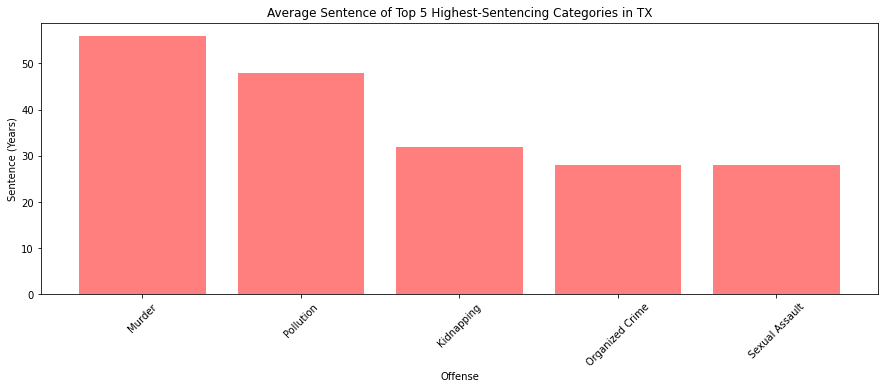

In [122]:
plt.bar(x_axis, top_5_offenses, color='r', alpha=0.5, align="center")
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, ["Murder", "Pollution", "Kidnapping", "Organized Crime", "Sexual Assault"], rotation = "45")
plt.title("Average Sentence of Top 5 Highest-Sentencing Categories in TX")
plt.xlabel("Offense")
plt.ylabel("Sentence (Years)")
fig = plt.gcf()
fig.set_size_inches(15, 5, forward=True)
plt.savefig("avg_sentence")

In [123]:
#Looking at "Murder", let's look at the 5 counties in TX that include the major cities 
#to observe their murder rate and average sentencing

In [124]:
#Top 5 Longest-Sentencing Offenses in TX (from above) narrowed down to biggest counties (around the major cities)

In [125]:
pd.set_option('display.max_column', 1000)
rcbinlookup_df.head()

,SID_Number,TDCJ_Number,Name,Current_Facility,Gender,Race,Age,Projected_Release,Max_Sentence_Date,Parole_Eligible_Date,Case_Number,County,Offense_Code,TDCJ_Offence,Sentence_Date,Offense_Date,Sentence_Years,Last_Parole_Decision,Next_Parole_Review,Parole_Review_Status,Offense_Category,Bin_Cat,Age_Bin
0,234378,2174505,"LITTLE,AVA JESSUP",Young,F,W,75,10/01/2020,11/15/2025,09/26/2018,068770,Grayson,35990003,POSS CS 4-200G WID METH,12/14/2017,09/13/2017,8.0,Approved on 07/01/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs,70_to_80
1,1116232,1366652,"SIDLE,JOHN ARTHUR",Pack,M,W,78,05/02/2021,06/18/2033,03/08/2016,F-0427284-IM,Dallas,35990003,UNLAW POSS WIT C/S-METHAM,04/06/2006,09/03/2004,25.0,Approved on 09/17/2020,NaN,NOT IN REVIEW PROCESS,2200,Drugs,70_to_80
2,1409034,729430,"LERMA,GILBERT LOPEZ",Wynne,M,H,70,01/01/9999,01/01/9999,08/22/2020,94-775-K368,Williamson,35990003,DEL C/S,09/19/1995,09/28/1994,50.9,Denied on 07/16/2020,07/2021,NOT IN REVIEW PROCESS,2200,Drugs,70_to_80
3,1468825,2205051,"EVANS,DAYTON BUD",Pack,M,W,70,04/21/2028,03/11/2043,10/20/2020,068250,Grayson,35990003,POSS CONT SUB PG1 4-200 WITD,03/12/2018,03/31/2017,25.0,Denied on 08/13/2020,08/2021,NOT IN REVIEW PROCESS,2200,Drugs,70_to_80
4,1473183,2038325,"GREEN,ROGER DALE SR",Duncan,M,W,73,08/16/2025,06/27/2040,02/14/2018,F49634,Johnson,35990003,DEL CONT SUB 4G-200G,11/10/2015,05/05/2015,25.0,Denied on 02/06/2020,02/2021,NOT IN REVIEW PROCESS,2200,Drugs,70_to_80


In [126]:
county_sentence_df = rcbinlookup_df[["County", "Sentence_Years", "Bin_Cat"]]
county_sentence_df['Sentence_Years'] = county_sentence_df['Sentence_Years'].astype(float)
county_sentence_df

<ipython-input-126-6b9ca088a9ae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_sentence_df['Sentence_Years'] = county_sentence_df['Sentence_Years'].astype(float)


,County,Sentence_Years,Bin_Cat
0,Grayson,8.0,Drugs
1,Dallas,25.0,Drugs
2,Williamson,50.9,Drugs
3,Grayson,25.0,Drugs
4,Johnson,25.0,Drugs
...,...,...,...
120702,Dallas,5.0,Human_Trafficking
120703,Cherokee,8.0,Unlawful_Use
120704,Ellis,10.0,Theft
120705,Starr,2.0,Sexual_Assault


In [127]:
harris_df = county_sentence_df.loc[county_sentence_df["County"] == "Harris", :]
harris_df

,County,Sentence_Years,Bin_Cat
47,Harris,25.0,Drugs
52,Harris,25.0,Drugs
55,Harris,25.0,Drugs
86,Harris,25.0,Drugs
90,Harris,12.0,Drugs
...,...,...,...
120630,Harris,50.9,Sexual_Assault
120633,Harris,3.0,Money_Laundering
120650,Harris,0.5,Fraud_Forgery
120695,Harris,1.0,Fraud_Forgery


In [128]:
harris_murder_df = harris_df.loc[harris_df["Bin_Cat"] == "Murder", :]
harris_murder_df

,County,Sentence_Years,Bin_Cat
9758,Harris,50.9,Murder
9763,Harris,50.9,Murder
9777,Harris,101.9,Murder
9779,Harris,50.9,Murder
9783,Harris,50.9,Murder
...,...,...,...
119955,Harris,101.9,Murder
119957,Harris,100.9,Murder
119961,Harris,100.9,Murder
120161,Harris,100.9,Murder


In [129]:
avg_harris_m = harris_murder_df['Sentence_Years'].mean()
avg_harris_m
r_avg_harris_m = round(avg_harris_m, 1)
r_avg_harris_m

58.8

In [130]:
dallas_df = county_sentence_df.loc[county_sentence_df["County"] == "Dallas", :]
dallas_df

,County,Sentence_Years,Bin_Cat
1,Dallas,25.0,Drugs
8,Dallas,25.0,Drugs
17,Dallas,65.0,Drugs
32,Dallas,8.0,Drugs
44,Dallas,25.0,Drugs
...,...,...,...
120619,Dallas,3.0,Human_Trafficking
120660,Dallas,5.0,Drugs
120661,Dallas,8.0,Drugs
120697,Dallas,15.0,Human_Trafficking


In [131]:
dallas_murder_df = dallas_df.loc[dallas_df["Bin_Cat"] == "Murder", :]
dallas_murder_df

,County,Sentence_Years,Bin_Cat
9749,Dallas,101.9,Murder
9750,Dallas,50.9,Murder
9755,Dallas,101.9,Murder
9757,Dallas,50.9,Murder
9760,Dallas,101.9,Murder
...,...,...,...
119934,Dallas,100.9,Murder
119937,Dallas,100.9,Murder
119941,Dallas,100.9,Murder
119949,Dallas,100.9,Murder


In [132]:
avg_dallas_m = dallas_murder_df['Sentence_Years'].mean()
avg_dallas_m
r_avg_dallas_m = round(avg_dallas_m, 1)
r_avg_dallas_m

57.2

In [133]:
tarrant_df = county_sentence_df.loc[county_sentence_df["County"] == "Tarrant", :]
tarrant_df

,County,Sentence_Years,Bin_Cat
22,Tarrant,15.0,Drugs
24,Tarrant,35.0,Drugs
37,Tarrant,9.0,Drugs
73,Tarrant,5.0,Drugs
101,Tarrant,70.0,Drugs
...,...,...,...
120662,Tarrant,3.0,Interference_Records
120666,Tarrant,10.0,Fraud_Forgery
120669,Tarrant,6.0,Fraud_Forgery
120673,Tarrant,6.0,Organized_Crime


In [147]:
tarrant_murder_df = tarrant_df.loc[tarrant_df["Bin_Cat"] == "Murder", :]
tarrant_murder_df

,County,Sentence_Years,Bin_Cat
9764,Tarrant,101.9,Murder
9781,Tarrant,40.0,Murder
9784,Tarrant,99.0,Murder
9863,Tarrant,40.0,Murder
9880,Tarrant,50.9,Murder
...,...,...,...
119953,Tarrant,100.9,Murder
119959,Tarrant,23.0,Murder
119966,Tarrant,30.0,Murder
119972,Tarrant,100.9,Murder


In [135]:
avg_tarrant_m = tarrant_murder_df['Sentence_Years'].mean()
avg_tarrant_m
r_avg_tarrant_m = round(avg_tarrant_m, 1)
r_avg_tarrant_m

58.1

In [136]:
bexar_df = county_sentence_df.loc[county_sentence_df["County"] == "Bexar", :]
bexar_df

,County,Sentence_Years,Bin_Cat
10,Bexar,25.0,Drugs
19,Bexar,15.0,Drugs
30,Bexar,35.0,Drugs
31,Bexar,8.0,Drugs
35,Bexar,5.0,Drugs
...,...,...,...
120620,Bexar,8.0,Human_Trafficking
120646,Bexar,1.0,Prostitution
120664,Bexar,10.0,Fraud_Forgery
120680,Bexar,3.0,Record_Tampering


In [137]:
bexar_murder_df = bexar_df.loc[bexar_df["Bin_Cat"] == "Murder", :]
bexar_murder_df

,County,Sentence_Years,Bin_Cat
9752,Bexar,50.9,Murder
9762,Bexar,198.0,Murder
9766,Bexar,75.0,Murder
9795,Bexar,75.0,Murder
9804,Bexar,40.0,Murder
...,...,...,...
117182,Bexar,101.9,Murder
117183,Bexar,101.9,Murder
117188,Bexar,101.9,Murder
117192,Bexar,101.9,Murder


In [138]:
avg_bexar_m = bexar_murder_df['Sentence_Years'].mean()
avg_bexar_m
r_avg_bexar_m = round(avg_bexar_m, 1)
r_avg_bexar_m

49.8

In [139]:
travis_df = county_sentence_df.loc[county_sentence_df["County"] == "Travis", :]
travis_df

,County,Sentence_Years,Bin_Cat
152,Travis,6.0,Drugs
211,Travis,7.0,Drugs
660,Travis,5.0,Drugs
709,Travis,8.0,Drugs
717,Travis,13.0,Drugs
...,...,...,...
120482,Travis,0.8,Theft
120500,Travis,10.0,Theft
120541,Travis,8.0,Human_Trafficking
120597,Travis,9.0,Alcohol_Incident


In [148]:
travis_murder_df = travis_df.loc[travis_df["Bin_Cat"] == "Murder", :]
travis_murder_df

,County,Sentence_Years,Bin_Cat
9751,Travis,50.9,Murder
9768,Travis,50.9,Murder
9770,Travis,99.0,Murder
9829,Travis,50.9,Murder
9837,Travis,50.9,Murder
...,...,...,...
116105,Travis,18.0,Murder
116291,Travis,11.0,Murder
116297,Travis,1.0,Murder
118313,Travis,101.9,Murder


In [141]:
avg_travis_m = travis_murder_df['Sentence_Years'].mean()
avg_travis_m
r_avg_travis_m = round(avg_travis_m, 1)
r_avg_travis_m

54.0

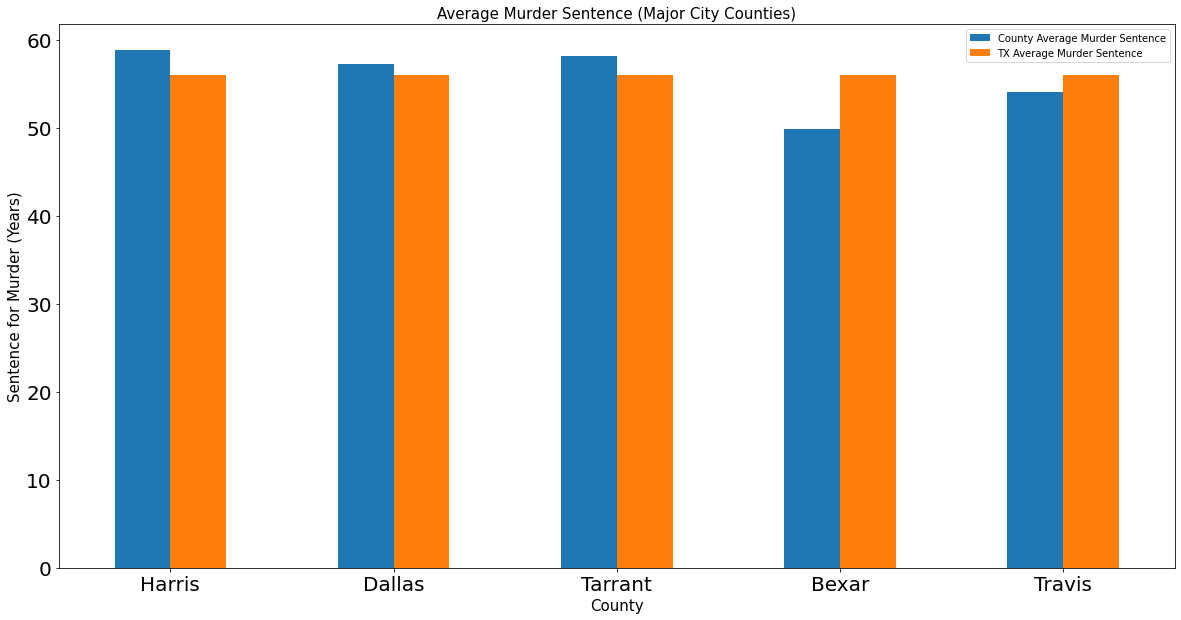

In [142]:
#Bar Graph
murder_sentence_df = [r_avg_harris_m, r_avg_dallas_m, r_avg_tarrant_m, r_avg_bexar_m, r_avg_travis_m]
tx_average_murder = [56.0, 56.0, 56.0, 56.0, 56.0]
index = ["Harris", "Dallas", "Tarrant", "Bexar", "Travis"]
df = pd.DataFrame({'County Average Murder Sentence': murder_sentence_df,
                   'TX Average Murder Sentence': tx_average_murder}, index=index)
ax = df.plot.bar(figsize=(20,10), rot = 0)
plt.title("Average Murder Sentence (Major City Counties)", fontsize = 15)
plt.xlabel("County", fontsize = 15)
plt.ylabel("Sentence for Murder (Years)", fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig("avg_murder.png")